<a href="https://colab.research.google.com/github/KhaldounN/Weather-Prediction-/blob/master/FINAL_DSF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [184]:
!pip3 install flair

In [185]:
!python -m spacy download en_core_web_lg
!python -m spacy download en_core_web_md

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_lg')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')


# Train Model to classify Emotions

                                               Input Sentiment
0                            i didnt feel humiliated   sadness
1  i can go from feeling so hopeless to so damned...   sadness
2   im grabbing a minute to post i feel greedy wrong     anger
3  i am ever feeling nostalgic about the fireplac...      love
4                               i am feeling grouchy     anger


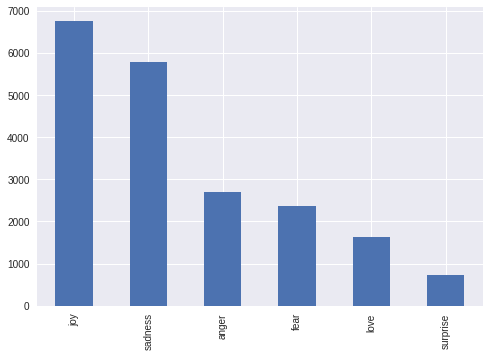

In [186]:
# Import data . data from source was saparerated so I can to concatenate it 

import pandas as pd 
from sklearn.model_selection import train_test_split

df_train = pd.read_csv('/content/train.txt', header =None, sep =';', names = ['Input','Sentiment'], encoding='utf-8')
df_test = pd.read_csv('/content/test.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df_val = pd.read_csv('/content/val.txt', header = None, sep =';', names = ['Input','Sentiment'],encoding='utf-8')
df = pd.concat([df_train,df_test, df_val])


#check data balance 
print(df.head())
df['Sentiment'].value_counts().plot(kind = 'bar')

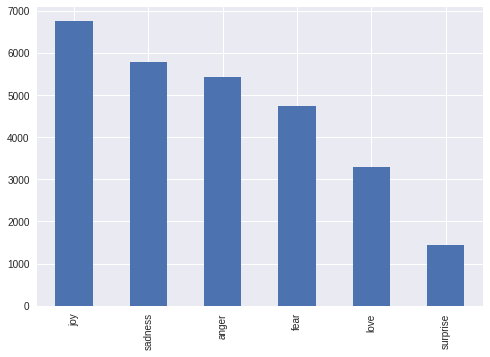

In [187]:
#douplicate the  imbalanced labels to balance data

df2 = df[df.Sentiment.isin(['fear','anger','love','surprise'])]
df = pd.concat([df,df2])
df['Sentiment'].value_counts().plot(kind = 'bar')

In [188]:
# Prepare Victorizer 
from sklearn.feature_extraction.text import CountVectorizer
from nltk.tokenize import RegexpTokenizer

token = RegexpTokenizer(r'[a-zA-Z0-9]+')
cv = CountVectorizer(stop_words='english', ngram_range=(1,1), tokenizer = token.tokenize)

# fit Victorizer 
X = cv.fit_transform(df['Input'])


In [189]:
#split data set 
from sklearn.model_selection import train_test_split

y = df['Sentiment']

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.15, random_state=20)

In [190]:
#intial and fit the ML model
from sklearn.ensemble import RandomForestClassifier
model_emotions = RandomForestClassifier()
model_emotions.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)

In [191]:
# Test Model and print Accuracy 
from sklearn import metrics
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score
from sklearn.metrics import confusion_matrix,classification_report

predicted = model_emotions.predict(X_test)
acc_score = metrics.accuracy_score(predicted,y_test)
prec_score = precision_score(y_test,predicted, average='macro')
recall = recall_score(y_test, predicted,average='macro')
f1 = f1_score(y_test,predicted,average='macro')
matrix = confusion_matrix(y_test,predicted)


print(str('Accuracy: '+'{:04.2f}'.format(acc_score*100))+'%')
print(str('Precision: '+'{:04.2f}'.format(prec_score*100))+'%')
print(str('Recall: '+'{:04.2f}'.format(recall*100))+'%')
print('F1 Score: ',f1)
print(matrix)


Accuracy: 93.56%
Precision: 92.84%
Recall: 94.43%
F1 Score:  0.935009797603684
[[773   2   0   0   3   0]
 [ 13 702   0   2   4   5]
 [ 12  12 915  51  30   9]
 [  0   0   9 453   0   0]
 [ 38  25  21  14 812   4]
 [  0  11   0   0   0 197]]


In [192]:
# manual check on Model 

In [193]:
text  = ['this makes me happy' , ' this is a  let down ', ' I am sad ', ' I am pissed off' , 'I liked him alot', ' it disgust me']
result =model_emotions.predict(cv.transform(text))

results = pd.DataFrame(text,result)
results

,0
joy,this makes me happy
anger,this is a let down
sadness,I am sad
anger,I am pissed off
love,I liked him alot
anger,it disgust me


In [202]:
# Save the model using pickle 
import pickle
filename = 'emotions_detector.sav'
pickle.dump(model_emotions, open(filename, 'wb'))

#test Loading the model 
loaded_model = pickle.load(open(filename, 'rb'))

# Importing needed libraries 


In [203]:
from flair.models import TextClassifier
from flair.data import Sentence
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use("seaborn")
import math
import plotly.express as px
import pandas as pd
import plotly.graph_objects as go
import warnings
import spacy


# Defining Functions 

In [221]:

# load book , clean data and split into sentences 
def Load_book(path):
  book = open(path, 'r').read()
  book = book.replace("\n",'')
  sentences  = book.split('.')

  return sentences 

# run sentiment analysis on each sentence in the book and save them into df_setiment 
def Analyzse_sentiment(sentences):
  warnings.filterwarnings('ignore')
  tagger = TextClassifier.load('sentiment')
  df_sentiment = pd.DataFrame((np.zeros((4,int(len(sentences))))))
  for i, sentence in enumerate(sentences):
    sentence = Sentence(sentence)
    tagger.predict(sentence)
    df_sentiment[i].update(sentence.labels)


  for i , sentence in enumerate(df_sentiment.iloc[0,:]):
      try:
        df_sentiment.iloc[1,i] = sentence.value
        if sentence.value == 'NEGATIVE':
          df_sentiment.iloc[2,i] = sentence.score * (-1)
        else:
          df_sentiment.iloc[2,i] = sentence.score
      except:
        pass

  return df_sentiment


# calcualte Major and Minor sentiment and vizualize it in a dashabord style

def Display_sentiment(df_sentiment  , booktitle = ' book title'):

  l = df_sentiment.iloc[2,:]
  l = pd.DataFrame(l) 
  l['Major'] = l.iloc[:,0].rolling(40).mean()
  l['Minor'] = l.iloc[:,0].rolling(10).mean()

  fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(30, 15))
  axes[0].set_title(booktitle , fontsize = 30 )
  axes[0].plot(l['Major'])
  axes[0].set_xlabel('Sentences' , fontsize=20)
  axes[0].set_ylabel('Sentiment', fontsize=20)
  axes[0].legend(['Major Sentiment(rolling average for 30 sentences)'], fontsize=20)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[0].fill_between(l.index, l['Major'] ,0 , where=l['Major'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[0].set_facecolor('white')
  axes[1].plot(l['Minor'])
  axes[1].set_xlabel('Sentences' , fontsize=15)
  axes[1].set_ylabel('Sentiment' , fontsize=15)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] >= 0, facecolor='lightgreen',  interpolate=True)
  axes[1].fill_between(l.index, l['Minor'] ,0 , where=l['Minor'] <= 0, facecolor='lightcoral',  interpolate=True)
  axes[1].set_facecolor('white')
  axes[1].legend(['Minor Sentiment(rolling average for 5 sentences)'] , fontsize=20)
# run emotions dedection on each sentence 
def Analyzse_Emotions(sentences):
  df_emotions = pd.DataFrame((np.zeros((1,int(len(sentences))))))
  filename = 'emotions_detector.sav'
  model = pickle.load(open(filename, 'rb'))
  for i , sentence in enumerate( sentences):
    try:
        result = model.predict(cv.transform([sentence]))
        df_emotions[i].update(result)
    except:
      pass
  return df_emotions


# perform calculations on df_emotions and display results 
def Display_emotions(df_emotions , booktitle = 'Book Title'):
  
  l = df_emotions.T.value_counts().index
  l = l.tolist()
  v = df_emotions.T.value_counts()
  v = v.tolist()
  fig = go.Figure(data=go.Scatterpolar(r=v,theta=l,fill='toself'))
  fig.update_layout(polar=dict(radialaxis=dict(visible=False),),showlegend=False)
  fig.show()


  df_emotions1 = df_emotions.T
  df_emotions1['Sentences(100)'] =  ((df_emotions1.index/100).astype(int))*100
  df_emotions1['1'] = df_emotions1.index
  data = df_emotions1.groupby(by=['Sentences(100)',0]).count()
  data = pd.DataFrame(data)
  data.reset_index(inplace=True)  
  data.columns = ['Sentences','Emotion','Count']
  fig = px.line(data,
                 x=	'Sentences' ,  y='Count', color='Emotion',
                 title="Emotions Detected ( every 100 sentences)")
  fig.update_layout(
  title={
        'text': str(booktitle),
        'y':0.9,
        'x':0.5,
        'xanchor': 'center',
        'yanchor': 'top'})

  fig.show()

def Analyze_entities(Senteces):
  df_ent = pd.DataFrame((np.zeros((100,int(len(sentences))))))
  df_ents = pd.DataFrame((np.zeros((3,int(len(sentences))))))
  l = []
  for i , sentence in enumerate(sentences):
    doc = nlp_md(sentence)
    df_ent[i].update(doc.ents)
  for  j , raw in df_ent.iteritems():
    for i , item in enumerate(raw):
      item2 = item
      if str(item2) != '0.0':
        l = [j , item.text , item.label_]
        df_ents[i].update(l)
  df_ents = df_ents.T
  df_ents = df_ents[df_ents[1] != 0]
  return df_ents
  

In [ ]:
sentences = Load_book('/content/The Birth of Tragedy.txt')
book_name = 'The Birth of Tragedy'
#sentences = sentences[:10]
df_sent = Analyzse_sentiment(sentences)
df_emo = Analyzse_Emotions(sentences)
df_ent = Analyze_entities(sentences)

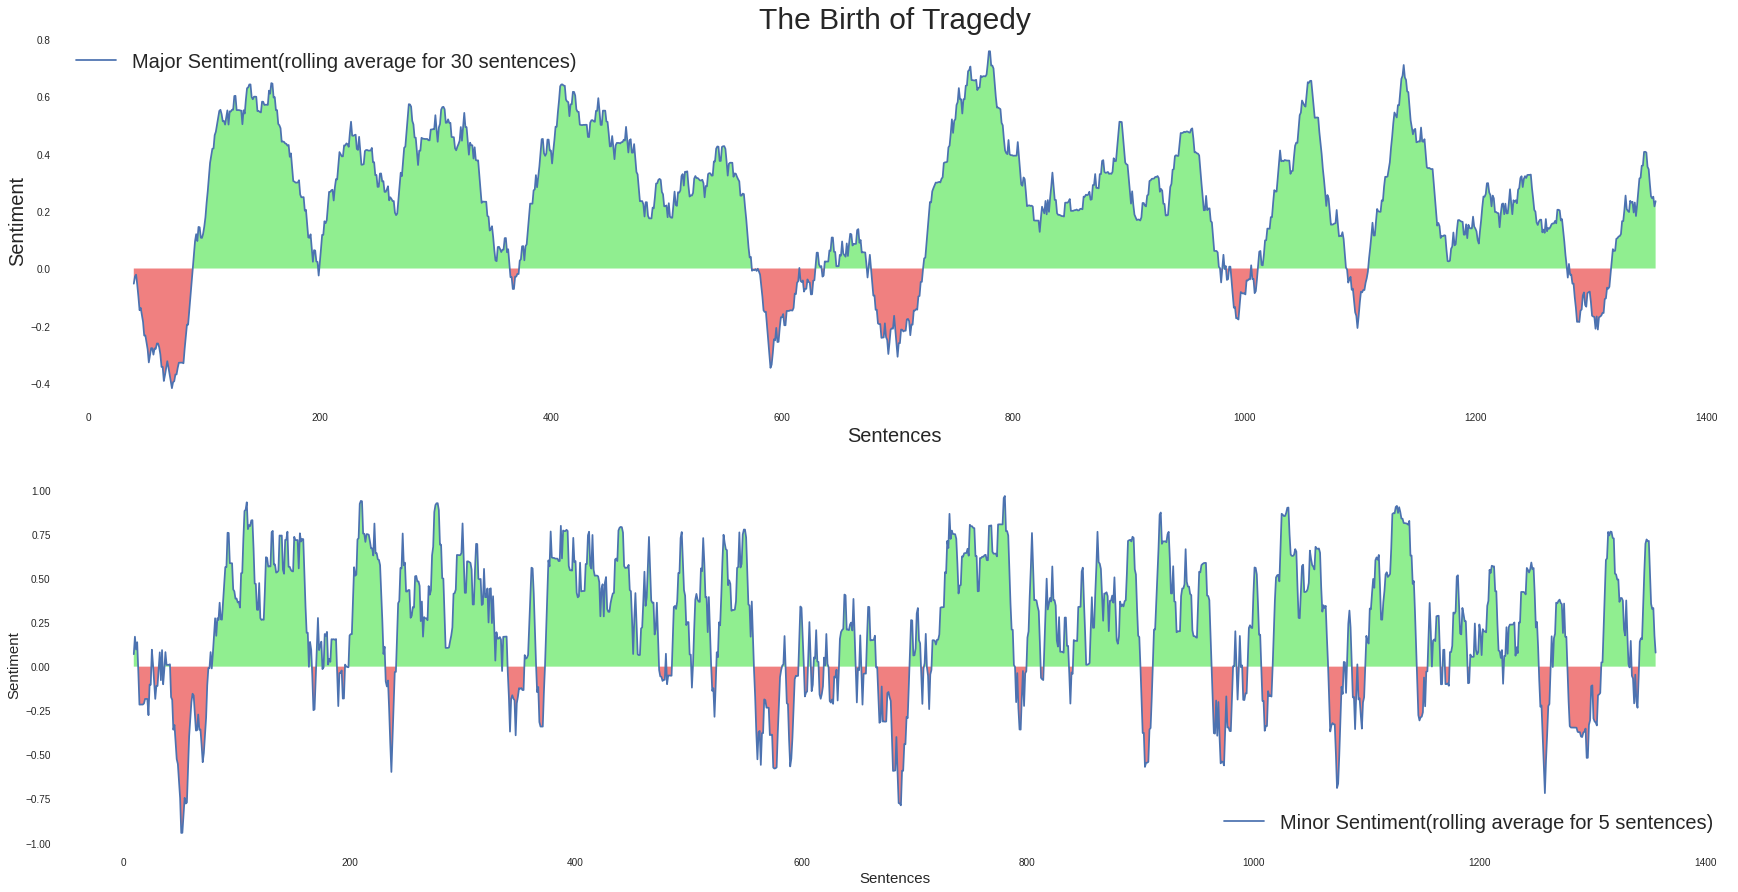

In [215]:
Display_sentiment(df_sent , book_name)
Display_emotions(df_emo , book_name)

In [216]:
sentences = Load_book('/content/Thus Spoke Zarathustra.txt')
book_name = 'Thus Spoke Zarathustra'
df_sent = Analyzse_sentiment(sentences)
df_emo = Analyzse_Emotions(sentences)
df_ent = Analyze_entities(sentences)

2020-12-13 11:36:28,213 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt
2020-12-13 11:36:30,523 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:37:39,648 Warning: An empty Sentence was created! Are there empty strings in your dataset?


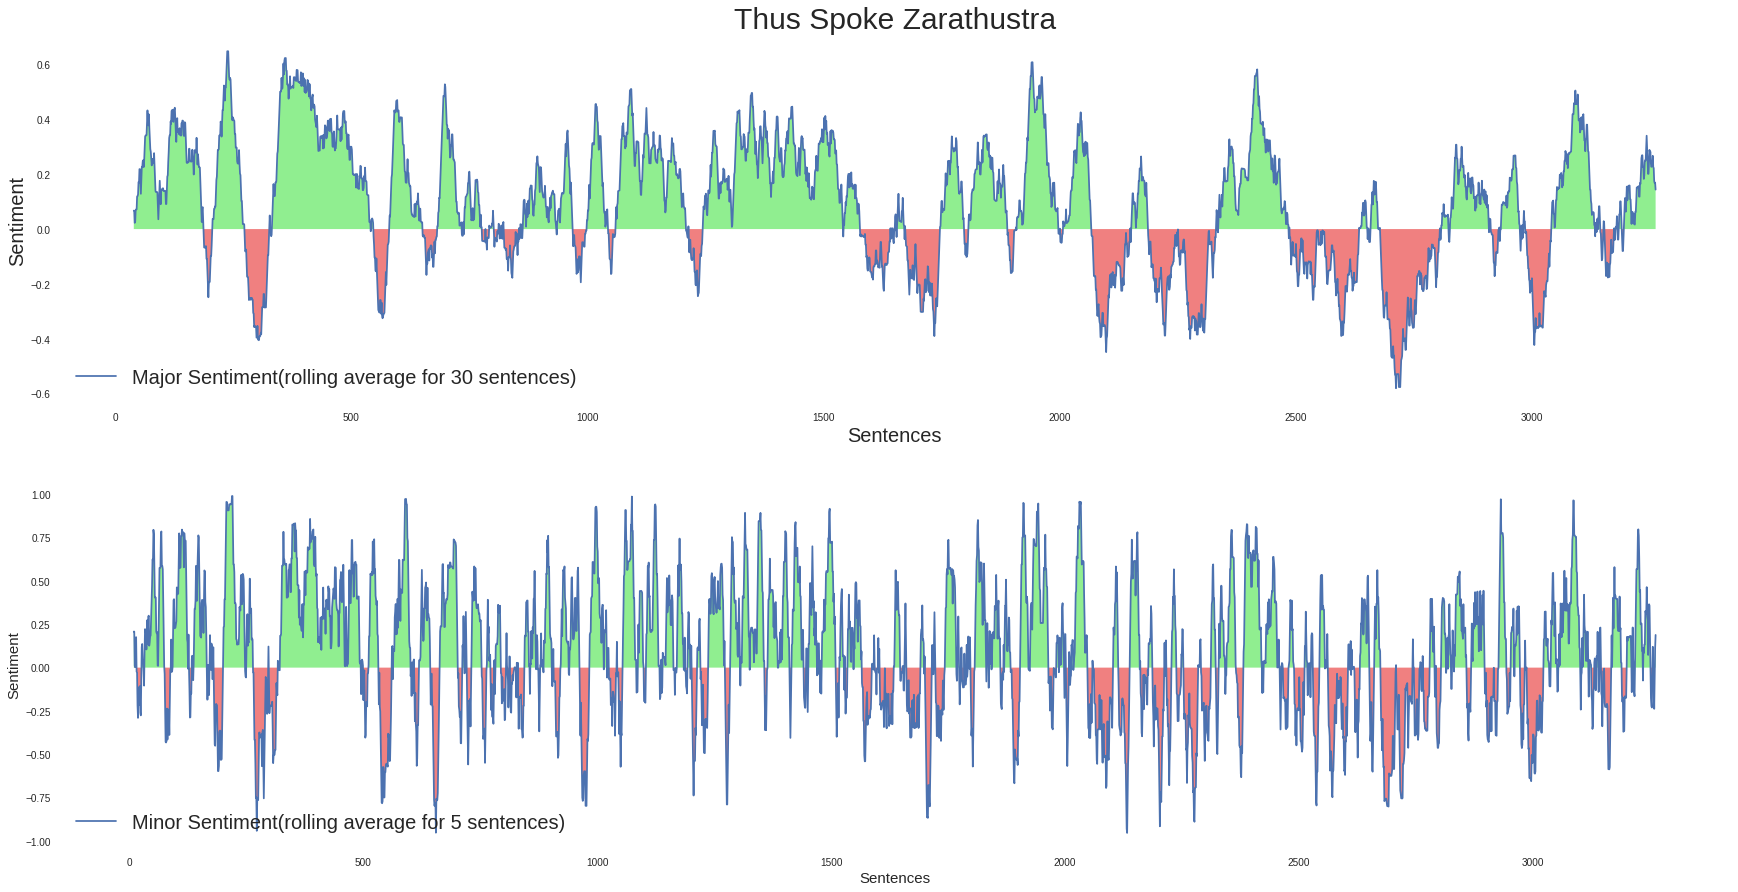

In [217]:
Display_sentiment(df_sent , book_name)
Display_emotions(df_emo , book_name)

In [218]:
sentences = Load_book('/content/On the Genealogy of Morality.txt')
book_name = 'On the Genealogy of Morality'
df_sent = Analyzse_sentiment(sentences)
df_emo = Analyzse_Emotions(sentences)
df_ent = Analyze_entities(sentences)

2020-12-13 11:43:26,998 loading file /root/.flair/models/sentiment-en-mix-distillbert_3.1.pt
2020-12-13 11:44:43,658 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:43,661 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,073 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,075 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,433 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,435 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,698 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,701 Warning: An empty Sentence was created! Are there empty strings in your dataset?
2020-12-13 11:44:46,705 Warning: An empty Sentence was created! Are

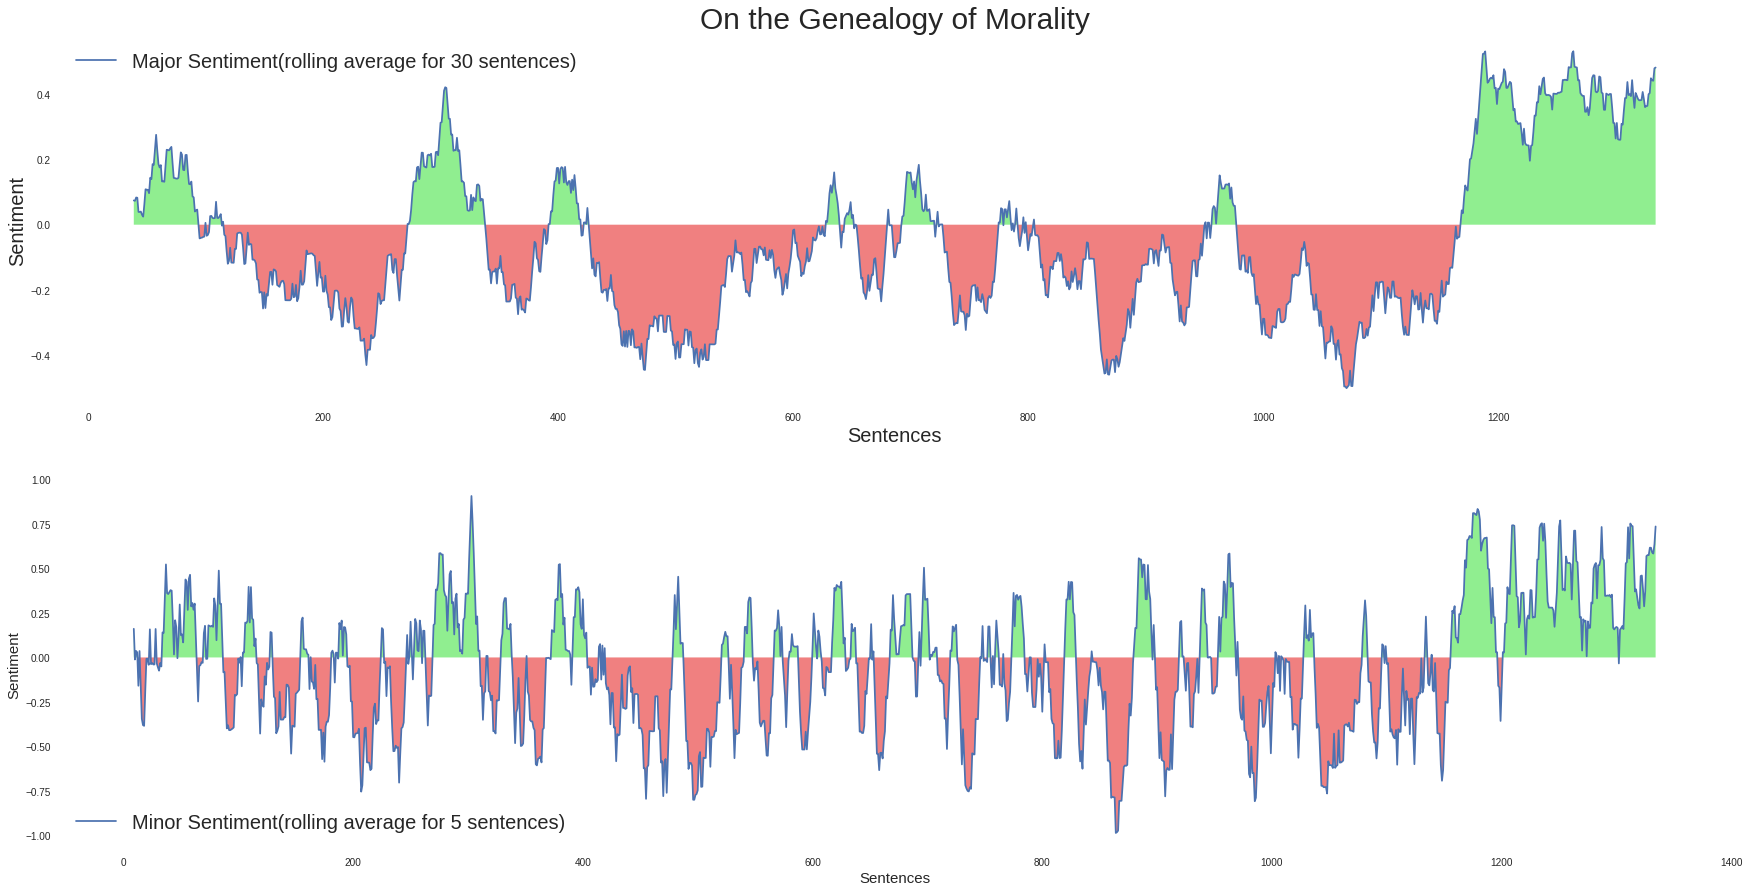

In [219]:
Display_sentiment(df_sent , book_name)
Display_emotions(df_emo , book_name)